In [8]:
import mangoes
from scipy.spatial.distance import cosine

# load pre-trained embeddings
path2embeddings = "ppmi_svd_1500words_win2/"
embedding = mangoes.Embeddings.load(path2embeddings)

# k-closest words
k = 10
lemma = "june"
try:
    print( "%s-NNs of word '%s':" %(k,lemma), embedding.get_closest_words(lemma, k) )
except KeyError:
    print("Oooops... Lemma '%s' not in vocabulary." %lemma)

# cosine distances
w1 = "june"
w2 = "july"
vec1 = embedding[w1]
vec2 = embedding[w2]
print( "Cosine distance between '%s' and '%s':" %(w1,w2), cosine(vec1,vec2) )


10-NNs of word 'june': [('april', 0.012472647863206787), ('december', 0.016593116529875385), ('february', 0.017868111709936518), ('october', 0.020471978042966299), ('august', 0.021974490312185901), ('july', 0.025274792074851504), ('january', 0.026281595875595309), ('september', 0.028087399062691976), ('march', 0.031459379964430489), ('november', 0.033697269602685376)]
Cosine distance between 'june' and 'july': 0.0252747920749


In [2]:
import mangoes
import string
path_to_corpus = "test"
corpus = mangoes.Corpus(path_to_corpus, lower=True)
vocabulary = corpus.create_vocabulary(filters=[mangoes.corpus.remove_elements(string.punctuation)])
cooccurrences = mangoes.counting.count_cooccurrence(corpus, vocabulary, vocabulary)
embeddings = mangoes.create_representation(cooccurrences,
                                            weighting=mangoes.weighting.PPMI(),
                                            reduction=mangoes.reduction.SVD(dimensions=200))
print(embeddings.get_closest_words("september", 3))

Exception: Traceback (most recent call last):
  File "/Users/deniscossu/Desktop/mangoes/utils/multiproc.py", line 125, in _create_queue
    for job in jobs:
  File "/Users/deniscossu/Desktop/mangoes/utils/reader.py", line 104, in sentences
    for line in reader:
  File "/Users/deniscossu/anaconda/lib/python3.6/fileinput.py", line 250, in __next__
    line = self._readline()
  File "/Users/deniscossu/anaconda/lib/python3.6/fileinput.py", line 364, in _readline
    return self._readline()
  File "/Users/deniscossu/anaconda/lib/python3.6/codecs.py", line 321, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf5 in position 5: invalid start byte


In [5]:
"""
This demo script creates a representation from a tokenized corpus using methods based on a matrix built by counting
co-occurrences of words in a corpus, applying PPMI and reducing the matrix to 50 dimensions with SVD

We use as a corpus a sample of 750K words from wikipedia articles, from which we extract a vocabulary of 1500 words.
This vocabulary is used both as target words (represented as vectors) and as contexts.
The cooccurrence matrix is generated from the corpus considering a symmetric windows of 2 words around the target word.

"""
import logging
import os.path

import matplotlib.pyplot as plt
import pandas as pd

import mangoes
import mangoes.visualize
import mangoes.evaluation.analogy
import mangoes.evaluation.similarity
import mangoes.evaluation.outlier

#########################
# HYPERPARAMETERS

VOCABULARY_SIZE = 1500
WINDOW_SIZE = 2  # symmetric window of 2 words before and 2 words after the target word
OUTPUT_PATH = os.path.join(os.path.dirname(__file__), "output")


def main():
    logging.basicConfig(level=logging.INFO)

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    # Corpus
    corpus = get_demo_corpus()

    # Vocabulary
    vocabulary = get_vocabulary(corpus)

    ############################
    # COUNTING THE COOCCURRENCES
    logging.info("Counting co-occurrences ...")
    cooccurrence_path = os.path.join(OUTPUT_PATH,
                                     "cooccurrence_{}words_win{}".format(VOCABULARY_SIZE, WINDOW_SIZE))

    # Using the previously created vocabulary as the list of words to represent and as the contexts,
    # we count the co-occurrences and create a sparse matrix with these counts
    # Then we save the resulting object (vocabulary + matrix) : it could be loaded the next time

    window = mangoes.context.Window(symmetric=True, window_half_size=WINDOW_SIZE, vocabulary=vocabulary)
    cooccurrence_matrix = mangoes.counting.count_cooccurrence(corpus, vocabulary, context=window)
    cooccurrence_matrix.save(cooccurrence_path)
    logging.info("Done. Cooccurrence counts and vocabulary saved in {}\n".format(cooccurrence_path))

    # You can also load a previously saved matrix by commenting the lines above and uncommenting the following
    # cooccurrence_matrix = mangoes.CountBasedRepresentation.load(cooccurrence_path)

    ############################
    # FROM COUNTING TO EMBEDDINGS
    logging.info("Creating the representation ...")
    embedding_path = os.path.join(OUTPUT_PATH,
                                  "embeddings/ppmi_svd_{}words_win{}".format(VOCABULARY_SIZE, WINDOW_SIZE))

    # From the cooccurrence counts, create vectors representing words in a mangoes.Embeddings objects,
    # applying ppmi and svd
    embedding = mangoes.create_representation(cooccurrence_matrix,
                                              weighting=mangoes.weighting.PPMI(),
                                              reduction=mangoes.reduction.SVD(dimensions=50, weight=0.5))
    embedding.save(embedding_path)
    logging.info("Done. Matrix and vocabulary saved in {}\n".format(embedding_path))

    # You can also load a previously saved embedding by commenting the lines above and uncommenting the following
    # embedding = mangoes.Embeddings.load(embedding_path)

    ##########################
    # EXPLORE THE EMBEDDINGS
    print("\n> EXPLORE")

    # 1. Closest words
    # you can have a list of the n closest words of a given word according to an embedding
    # To do so, use the get_closest_words() method
    # Here we will display the 3 closest words of 10 words of our vocabulary
    print("\n>> Closest words :")

    result = {word: pd.Series([w for w, _ in embedding.get_closest_words(word, nb=3)], index=[1, 2, 3])
              for word in embedding.words[100:200:10]}
    print(pd.DataFrame(result).transpose())

    # 2. Analogies
    print("\n>> Analogies :")
    # You can resolve analogy according to a representation using the analogy() method
    # Here, we will display the results of some examples :
    for analogy in ['great greater good', 'india indian japan', 'king queen man', 'london england paris']:
        print(analogy, '->', embedding.analogy(analogy).using_cosadd[0])


    ##########################
    # EVALUATE THE EMBEDDINGS

    print("\n> EVALUATION")

    # The package mangoes.evaluation provides different ways to evaluate a representation :

    # 1. Analogy task
    print("\n>> Analogy :")
    # the class mangoes.evaluation.analogy.Evaluation can run evaluation according to the available analogy datasets
    # (Google and MSR) and/or to your own and print a report
    analogy_evaluation = mangoes.evaluation.analogy.Evaluation(embedding, mangoes.evaluation.analogy.GOOGLE)
    print(analogy_evaluation.get_report(show_subsets=True))

    # 3. Similarity task
    print("\n>> Similarity :")
    # the class mangoes.evaluation.similarity.Evaluation can run evaluation according to the available word similarity
    # datasets (WS353, Rarreword, MEN, ...) and/or to your own and print a report
    similarity_evaluation = mangoes.evaluation.similarity.Evaluation(embedding, *mangoes.evaluation.similarity.ALL_DATASETS)
    print(similarity_evaluation.get_report())

    # 4. Outlier detection
    print("\n>> Outlier detection :")
    # the class mangoes.evaluation.outlier.Evaluation can run evaluation according to the available analogy datasets
    # (8-8-8 and WikiSem500) and/or to your own and print a report
    outlier_detection_evaluation = mangoes.evaluation.outlier.Evaluation(embedding,
                                                                         *mangoes.evaluation.outlier.ALL_DATASETS,
                                                                         lower=True)
    print(outlier_detection_evaluation.get_report())

    ##########################
    # VISUALIZE

    plt.figure()

    # 1. distances between the words
    ax = plt.subplot(221, projection='polar')
    mangoes.visualize.plot_distances(embedding, ax)

    # 2. isotropy
    ax = plt.subplot(222)
    mangoes.visualize.plot_isotropy(embedding, ax)

    # 3. t-sne
    plt.subplot(212)
    mangoes.visualize.plot_tsne(embedding)

    plt.show()


def get_demo_corpus():
    """
    Creates a mangoes.Corpus object from an example file

    Returns
    -------
    mangoes.Corpus
    """
    corpus_metadata = os.path.join(os.path.dirname(__file__), "output/.corpus")
    try:
        logging.info("Loading corpus metadata ...")
        corpus = mangoes.Corpus.load_from_metadata(corpus_metadata)
    except FileNotFoundError:
        logging.info("Counting corpus words and sentences ...")
        corpus_path = os.path.join(os.path.dirname(__file__), "data/sample_en_tokenized_750K.txt")
        corpus = mangoes.Corpus(corpus_path, nb_sentences=750000, lower=True)
        corpus.save_metadata(corpus_metadata)
    logging.info("Done. Corpus has {} sentences, {} different words, {} tokens".format(corpus.nb_sentences,
                                                                                       len(corpus.words_count),
                                                                                       corpus.size))
    return corpus


def get_vocabulary(corpus):
    """
    From a corpus, we extract a vocabulary (i.e. a set of words) with the most frequent words.
    Or load a previously created and saved vocabulary

    Parameters
    ----------
    corpus : mangoes.Corpus

    Returns
    -------
    mangoes.Vocabulary
    """

    vocabulary_file_name = "vocabulary_{}_words".format(VOCABULARY_SIZE)
    try:
        logging.info("Loading vocabulary ...")
        vocabulary = mangoes.Vocabulary.load("output", vocabulary_file_name)
    except FileNotFoundError:
        logging.info("Extracting vocabulary from corpus ...")
        import string
        remove_punctuation = mangoes.corpus.remove_elements(string.punctuation)
        vocabulary = corpus.create_vocabulary(filters=[remove_punctuation, mangoes.corpus.truncate(VOCABULARY_SIZE)])
        vocabulary.save(os.path.join(os.path.dirname(__file__), "output"), name=vocabulary_file_name)

    logging.info("Done.\n")
    return vocabulary


if __name__ == "__main__":
    exit(main())

NameError: name '__file__' is not defined

In [11]:
from nltk.corpus import wordnet as wn

In [12]:
dog = wn.synset('dog.n.01')
dog.hypernyms()

[Synset('canine.n.02'), Synset('domestic_animal.n.01')]

In [36]:
memory = wn.synset('memory.n.01')
memory.hypernyms()
learning = wn.synset('learning.n.01')
learning.hypernyms()

[Synset('basic_cognitive_process.n.01')]

In [32]:
association = wn.synset('association.n.04')
association.hypernyms()

print(wn.synset('memory.n.02').definition())
print(wn.synset('learning.n.01').definition())
wn.synset('association.n.04').definition()

the cognitive processes whereby past experience is remembered
the cognitive process of acquiring skill or knowledge


'the process of bringing ideas or events together in memory or imagination'

In [34]:
memory.path_similarity(association)

0.125

In [37]:
memory.path_similarity(learning)

0.14285714285714285

In [387]:
wn.synset('association.n.01').path_similarity(learning)

0.1

In [ ]:
association.path_similarity(learning)

In [46]:
import matplotlib

In [47]:
plot(association.path_similarity(learning))

NameError: name 'plot' is not defined

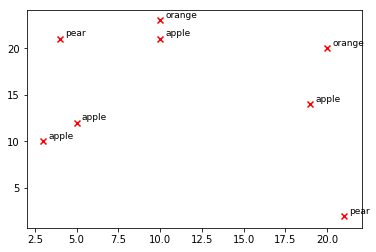

In [80]:
import matplotlib.pyplot as plt

# simulating a pandas df['type'] column
types = ['apple', 'orange', 'apple', 'pear', 'apple', 'orange', 'apple', 'pear']
x_coords = [10, 10, 5, 4, 3, 20, 19, 21]
y_coords = [21, 23, 12, 21, 10, 20, 14, 2]

for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, type, fontsize=9)
plt.show()

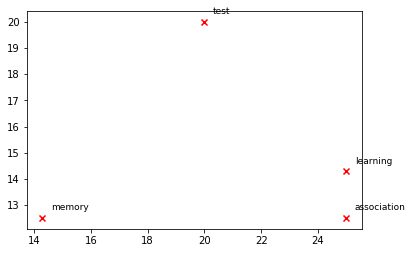

In [85]:
import matplotlib.pyplot as plt

# simulating a pandas df['type'] column
types = ['learning', 'association', 'memory',"test"]
x_coords = [100*learning.path_similarity(association),100* association.path_similarity(learning), 100*memory.path_similarity(learning),20]
y_coords = [100*learning.path_similarity(memory),100*association.path_similarity(memory),100*memory.path_similarity(association),20]

for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, type, fontsize=9)
plt.show()

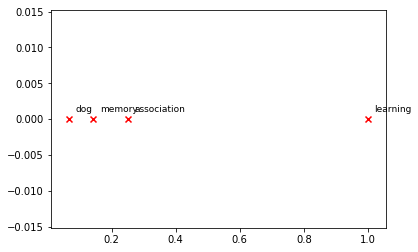

In [95]:
import matplotlib.pyplot as plt

# simulating a pandas df['type'] column
types = ['learning', 'association', 'memory',"dog"]
x_coords = [learning.path_similarity(learning),learning.path_similarity(association),learning.path_similarity(memory),learning.path_similarity(dog)]
y_coords = [0,0,0,0]

for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.02, 0.001, type, fontsize=9)
plt.show()

In [470]:
def synset(word,number=1):
    return wn.synset(word + '.n.0' + str(number))

synset("lapin")

Synset('lapin.n.01')

In [495]:
def wordWithSynset(word) :
    if type(word) == type("string") :
        return wn.synset(word + '.n.01')
    elif type(word) == type([]) :
        return wn.synset(word[0] + '.n.0' + str(word[1]))
    else :
        return "error"

In [506]:
print(wordWithSynset(["word",2]))
print(wordWithSynset("word"))

Synset('word.n.02')
Synset('word.n.01')


In [547]:
def graph_similarity(words ,wordCompare, highlightWords = [], similarity = "path_similarity" ,loga = True):
   
    x_coords = []
    y_coords = []
    decalage = 0
    highlightWordsString = []
    
    for word in highlightWords :
        if type(word) == type([]) : 
            highlightWordsString.append(word[0])
        else :
            highlightWordsString.append(word)

        
    words =  highlightWords + [wordCompare] + words
    
    for word in words :
        
        addX = wordWithSynset(wordCompare).path_similarity(wordWithSynset(word))

        
        if (similarity == "lch_similarity") :
             addX = wordWithSynset(wordCompare).lch_similarity(wordWithSynset(word))
            
        elif (similarity == "wup_similarity") :
             addX = wordWithSynset(wordCompare).wup_similarity(wordWithSynset(word))

       
        
        if (loga == True and similarity != "lch_similarity" ): 
            #valeur en log pour augmenter la diffèrence entre les mots éloignés du mot cible
            #lch_similarity déjà en log
            addX = log(addX)
        
        
        x_coords.append(addX)
        decalage += 0.1
        y_coords.append(decalage)
        
    if (loga == True and similarity != "lch_similarity" ): 
        similarity += " (en log)"
    
    
    if type(wordCompare) == type([]) :
        wordCompare = wordCompare[0]

    for i,word in enumerate(words):
        
        if type(word) == type([]) : 
            word = word[0]
        
        x = x_coords[i]
        y = y_coords[i]
        if word in highlightWordsString :
            plt.scatter(x, y, marker='X', color='blue')
            print(word +'|' + wordCompare + " : " + str(x))
        elif word == wordCompare :
            plt.scatter(x, y, marker='*', color='green')
        else :
            plt.scatter(x, y, marker='x', color='red')
        plt.text(x+0.02, y, word, fontsize=9)
    highlightWords.clear()
        
    axes = plt.gca()
    axes.set_xlabel('distance avec le mot \'' + wordCompare + "\' par " + similarity)
    axes.yaxis.set_visible(False)
    

    plt.show()

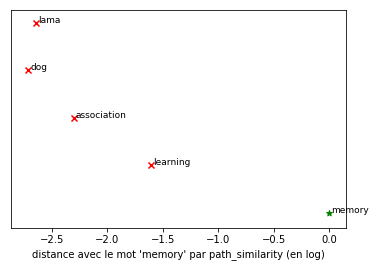

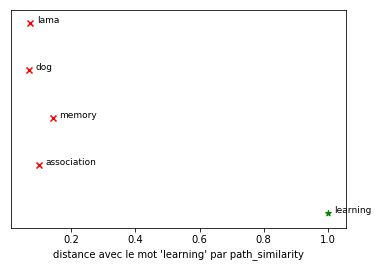

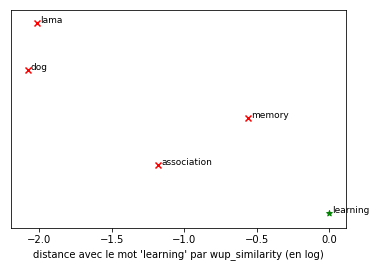

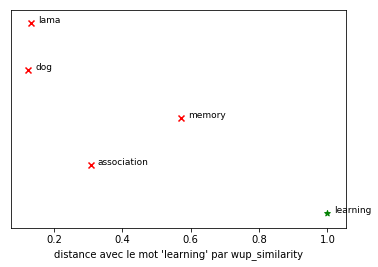

In [545]:
graph_similarity([['learning',2], 'association',"dog", "lama"],"memory" )
graph_similarity([ 'association', 'memory',"dog", "lama"],"learning",loga =False )
graph_similarity([ 'association', 'memory',"dog", "lama"],"learning", similarity = "wup_similarity" )
graph_similarity([ 'association', 'memory',"dog", "lama"],"learning",loga =False, similarity = "wup_similarity" )

In [413]:
from math import log
log(2,10)

0.30102999566398114

learning|memory : -0.5596157879354228
association|memory : -1.1786549963416462


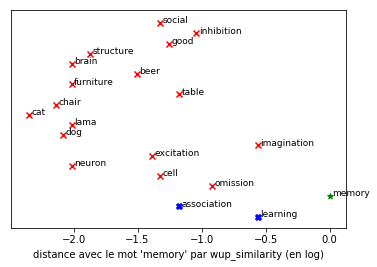

In [435]:
graph_similarity(["omission","cell","neuron","excitation","imagination","dog", "lama","cat","chair","table","furniture","beer","brain","structure","good","inhibition", "social"],"memory",['learning', 'association'] , similarity = "wup_similarity" )

learning|memory : 0.5714285714285714
association|memory : 0.3076923076923077


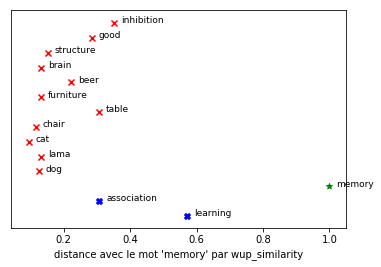

In [436]:
graph_similarity(["dog", "lama","cat","chair","table","furniture","beer","brain","structure","good","inhibition"],"memory",['learning', 'association'] , similarity = "wup_similarity",loga =False )

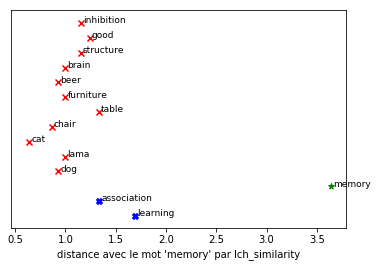

In [416]:
graph_similarity(["dog", "lama","cat","chair","table","furniture","beer","brain","structure","good","inhibition"],"memory",['learning', 'association'] , similarity = "lch_similarity" )

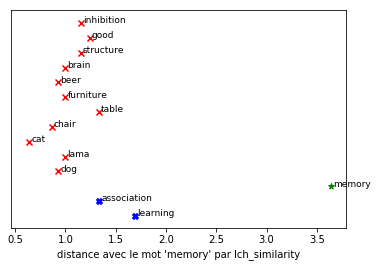

In [417]:
graph_similarity(["dog", "lama","cat","chair","table","furniture","beer","brain","structure","good","inhibition"],"memory",['learning', 'association'] , similarity = "lch_similarity",loga =False  )

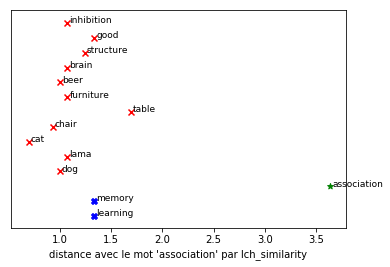

In [418]:
graph_similarity(["dog", "lama","cat","chair","table","furniture","beer","brain","structure","good","inhibition"],"association",['learning', 'memory'] , similarity = "lch_similarity",loga =False  )

In [447]:
listOfWords = ["omission","cell","knowledge", "experience","neuron","excitation","imagination","dog", "skill", "event","lama","cat","chair","table","furniture","beer","brain","structure","good","inhibition", "social", "process"]

learning|memory : -0.15415067982725836
association|memory : -0.06899287148695143


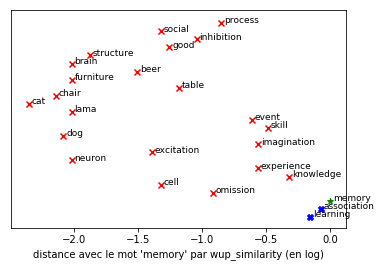

memory|learning : -0.15415067982725836
association|learning : -0.2231435513142097


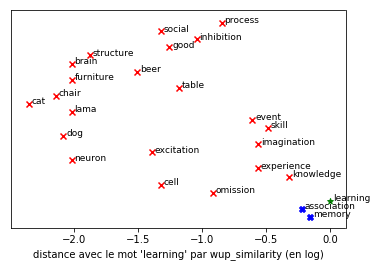

learning|association : -0.2231435513142097
memory|association : -0.06899287148695143


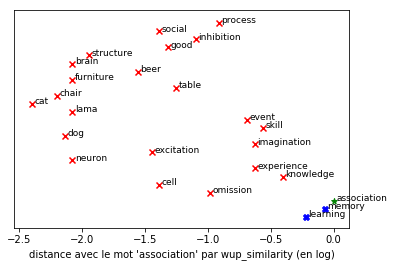

In [551]:
graph_similarity( listOfWords,["memory",2],['learning', ['association',4]], similarity = "wup_similarity" )
graph_similarity(listOfWords,"learning",[["memory",2], ['association',4]] , similarity = "wup_similarity" )
graph_similarity(listOfWords,['association',4],['learning', ["memory",2]] , similarity = "wup_similarity" )

In [452]:
print(wn.synset('memory.n.02').definition())
print(wn.synset('learning.n.01').definition())
wn.synset('association.n.04').definition()

the cognitive processes whereby past experience is remembered
the cognitive process of acquiring skill or knowledge


'the process of bringing ideas or events together in memory or imagination'

In [557]:
for synset in list(wn.all_synsets('n')):
    if synset.wup_similarity(memory)>0.9 :
        print(synset)

Synset('reminiscence.n.01')
Synset('representation.n.01')
Synset('memory.n.01')
Synset('recollection.n.03')
Synset('engram.n.01')
Synset('confabulation.n.02')
Synset('screen_memory.n.01')


In [558]:
for synset in list(wn.all_synsets('n')):
    if synset.wup_similarity(learning)>0.9 :
        print(synset)

Synset('basic_cognitive_process.n.01')
Synset('learning.n.01')
Synset('conditioning.n.01')
Synset('developmental_learning.n.01')
Synset('digestion.n.03')
Synset('education.n.03')
Synset('internalization.n.01')
Synset('imprinting.n.01')
Synset('language_learning.n.01')
Synset('memorization.n.01')
Synset('study.n.02')
Synset('transfer.n.05')


In [560]:
for synset in list(wn.all_synsets('n')):
    if synset.wup_similarity(association)>0.85 :
        print(synset)

Synset('basic_cognitive_process.n.01')
Synset('memory.n.02')
Synset('short-term_memory.n.01')
Synset('working_memory.n.01')
Synset('long-term_memory.n.01')
Synset('retrieval.n.02')
Synset('recall.n.04')
Synset('recognition.n.02')
Synset('association.n.04')
Synset('colligation.n.02')
Synset('retrospection.n.02')
Synset('generalization.n.01')
